# Salary Predictions Based on Job Descriptions

We want to predict the salary of a professional based on the data we are given. The data gives us information of the individual's jobID, companyID, the type of job, degree, major, industry (ALL categorical features) and years of experience and miles from Metropolis (numerical features).

In [168]:

import pandas as pd
import sklearn as sk
import numpy as np
import xgboost as xg
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn import ensemble
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

__author__ = "Thu Nguyen"
__email__ = "thumn6@uci.edu"

### Exploratory Data Analysis

#### Load data and get an overview

In [144]:

features = pd.read_csv("./data/train_features.csv")
salaries = pd.read_csv("./data/train_salaries.csv")
features_salary = pd.merge(features,salaries);
print(features.shape)
features.head()


(1000000, 8)


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


#### Look for null values

In [117]:

print (features.isnull().sum())

print (features.isnull().values.any())

print (features.isnull().sum().sum())

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64
False
0


A visual graph of any null values, any blank space means there is a null value, full block means no null values.

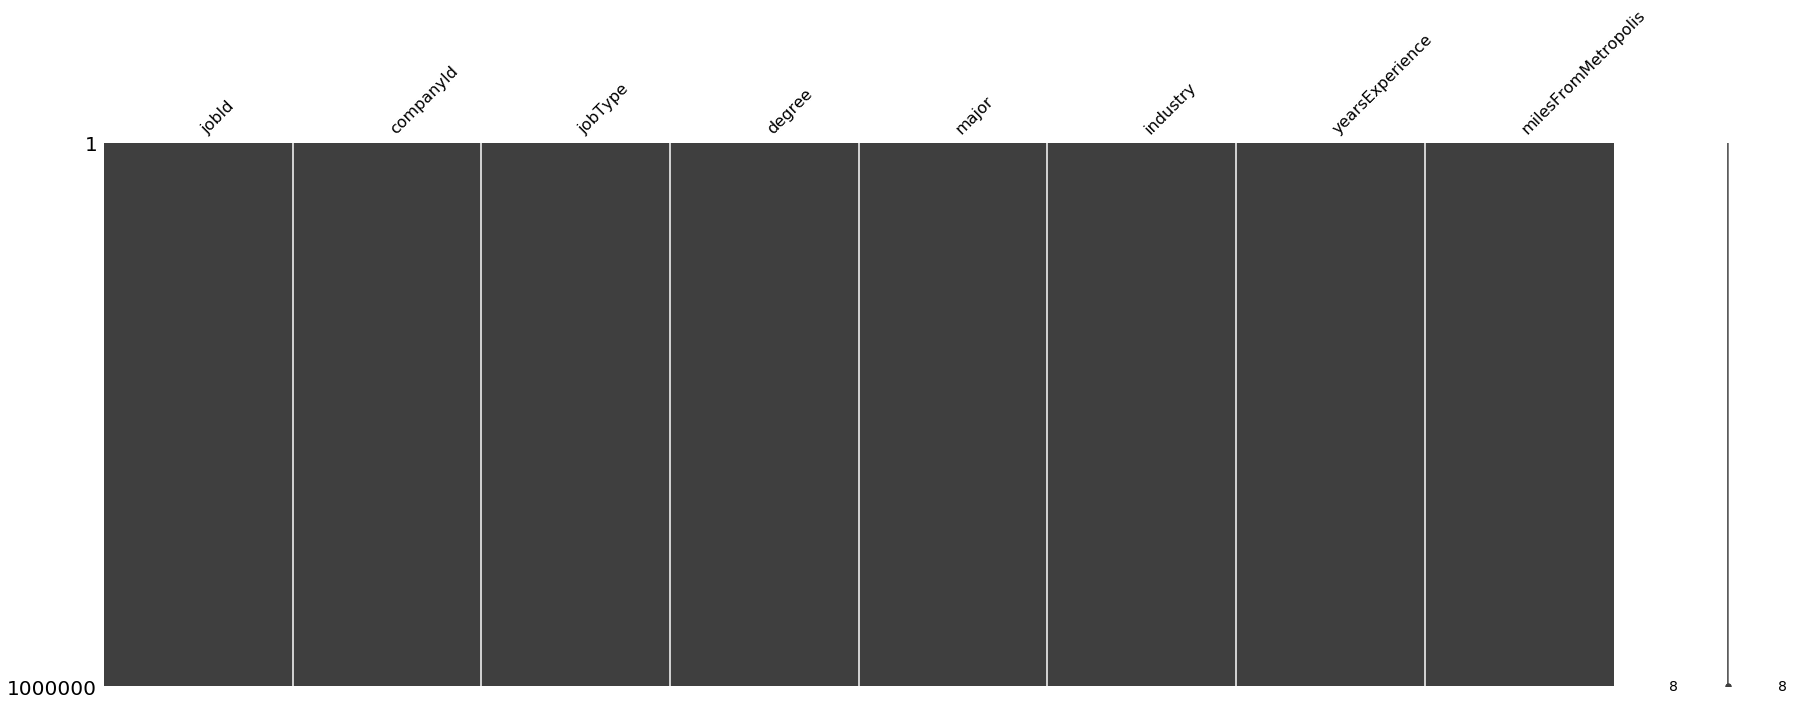

In [118]:
import missingno as msno
msno.matrix(features, figsize=(30,10))

#### Look for the correlation between each features vs salary

In [119]:
features_salary.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [120]:
print(features_salary.groupby(['degree'])['salary'].mean());

degree
BACHELORS      125.454663
DOCTORAL       135.489433
HIGH_SCHOOL    101.920654
MASTERS        130.504903
NONE            98.176467
Name: salary, dtype: float64


In [121]:
print(features_salary.groupby(['jobType'])['salary'].mean());

jobType
CEO               145.311425
CFO               135.458547
CTO               135.479983
JANITOR            70.813045
JUNIOR             95.331557
MANAGER           115.367596
SENIOR            105.487775
VICE_PRESIDENT    125.367629
Name: salary, dtype: float64


In [122]:
print(features_salary.groupby(['major'])['salary'].mean());

major
BIOLOGY        127.932664
BUSINESS       135.648980
CHEMISTRY      129.072085
COMPSCI        132.075605
ENGINEERING    138.436617
LITERATURE     124.423097
MATH           133.319735
NONE           102.583479
PHYSICS        130.372436
Name: salary, dtype: float64


In [123]:
print(features_salary.groupby(['industry'])['salary'].mean());

industry
AUTO         109.433690
EDUCATION     99.448386
FINANCE      130.746743
HEALTH       115.735540
OIL          130.952946
SERVICE      104.446820
WEB          121.644512
Name: salary, dtype: float64


Text(0.5, 1.0, 'Miles from metropolis vs Salary')

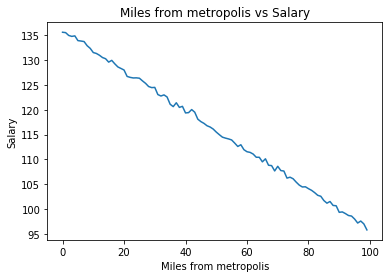

In [125]:
x = np.sort(features['milesFromMetropolis'].unique());
y = features_salary.groupby(['milesFromMetropolis'])['salary'].mean();
plt.plot(x,y);
plt.xlabel("Miles from metropolis");
plt.ylabel('Salary')
plt.title("Miles from metropolis vs Salary")

Text(0.5, 1.0, 'Years of experience vs Salary')

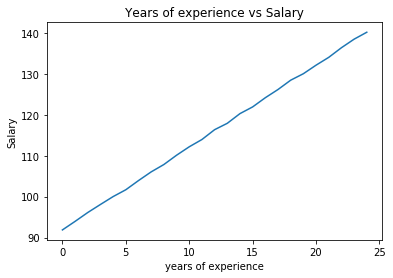

In [126]:
x1 = np.sort(features['yearsExperience'].unique());
y1 = features_salary.groupby(['yearsExperience'])['salary'].mean();
plt.plot(x1,y1);
plt.xlabel("years of experience");
plt.ylabel('Salary')
plt.title("Years of experience vs Salary")

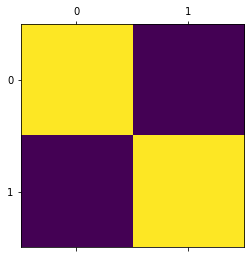

In [127]:
plt.matshow(features.corr())
plt.show()

### Look for outliers

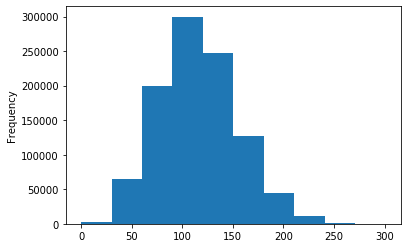

In [135]:
salaries.salary.plot.hist()

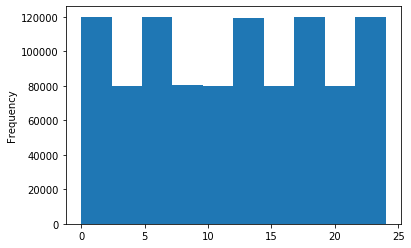

In [137]:
features.yearsExperience.plot.hist()

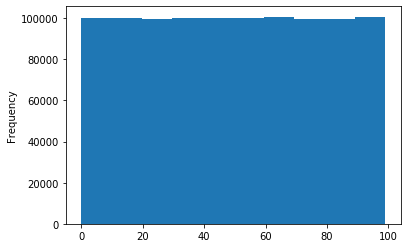

In [138]:
features.milesFromMetropolis.plot.hist()

### Baseline Model - predicting salary based on the industry alone

In [139]:

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

def baselineModel(train_features, train_salaries):
    
    industry_salary = pd.merge(train_features,train_salaries);
    industry_vs_salary = industry_salary.groupby(['industry']).mean();
    return industry_vs_salary;







#### Use 5 fold cross validation to evaluate baseline model

In [140]:
kf = KFold(n_splits=5);

mse_list_baseline = [];
index = kf.split(features);
for train_index, test_index in index:
   
    train_features, test_features = features.iloc[train_index], features.iloc[test_index]
    train_salary, test_salary = salaries.iloc[train_index], salaries.iloc[test_index]
    model = baselineModel(train_features, train_salary);
    predicted_salary = pd.merge(test_features, model, on ='industry');
    mse_list_baseline.append(mean_squared_error(test_salary['salary'], predicted_salary['salary']))

In [141]:
print("MSE", np.array(mse_list_baseline).mean())

MSE 1630.8646405439122


### Data Preprocessing for training ML models

#### Drop columns that might be irrelevant to salaries, like jobID and companyID

In [147]:
features = features.drop(columns=['jobId', 'companyId'])

#### Convert nominal and ordinal columns into numerical columns

In [ ]:
replace_map = {'degree': {'NONE': 98, 'HIGH_SCHOOL':101, 'BACHELORS':125,'MASTERS':130,'DOCTORAL':135}
               , 'jobType': {'JANITOR' : 70, 'JUNIOR':95, 'SENIOR':105, 'MANAGER':115, 'CEO':145, 
                'CFO':135, 'CTO':135, 'VICE_PRESIDENT':125}};
features = features.replace(replace_map);
features.head()

In [148]:
cat_features = ['degree','jobType'];
cat_features_2 = ['major','industry'];
numerical_features = ['yearsExperience', 'milesFromMetropolis','degree','jobType'];
for cat in cat_features:
    features[cat] = preprocessing.LabelEncoder().fit_transform(features[cat])
categorical_df = pd.get_dummies(features[cat_features_2], drop_first=True)

features = pd.concat([categorical_df,features[numerical_features]],axis=1)
features.head()

,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis,degree,jobType
0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,10,83,3,5
1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,3,73,1,6
2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,10,38,4,4
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,8,17,4,3
4,0,0,0,0,0,0,0,1,0,1,0,0,0,0,8,16,2,4


In [149]:
features.shape

(1000000, 18)

In [150]:
features.head()

,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis,degree,jobType
0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,10,83,3,5
1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,3,73,1,6
2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,10,38,4,4
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,8,17,4,3
4,0,0,0,0,0,0,0,1,0,1,0,0,0,0,8,16,2,4


#### Looking for correlations between features and features vs target

In [153]:
def cross_val(model, f, s):
    kf = KFold(n_splits=5);
    mse_list = [];
    for train_index, test_index in kf.split(f):
    
        train_features, test_features = f.iloc[train_index], f.iloc[test_index]
        train_salary, test_salary = s.iloc[train_index], s.iloc[test_index];
    
        model.fit(train_features, train_salary['salary'])
    
    
   
        mse_list.append(mean_squared_error(test_salary['salary'], model.predict(test_features)));
    print("MSE: %.4f" % np.array(mse_list).mean())

### Developing ML models

### Linear Regression

In [155]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 
linearL = linear_model.LinearRegression()
cross_val(linearL, features, salaries)
#590 ->530 -> 535 -> 385

MSE: 385.1080


### Decision Tree

In [157]:
dtree = DecisionTreeRegressor(random_state=0)
# mse 674 - 418 - 637

In [158]:
cross_val(dtree, features, salaries)

MSE: 678.8706


### Random Forest

In [159]:
random_forest = RandomForestRegressor(max_depth=6, random_state=0)
# mse 565 -> 555

In [160]:
cross_val(random_forest, features, salaries)

MSE: 560.7753


### XGBoost

In [161]:
xgb = XGBRegressor(silent=1);
cross_val(xgb, features, salaries)
# mse 386 first try -> 385 -> 393 when dropping major column -> 384


MSE: 368.6076


We will pick the model XGBoost to tune the hyperparameters and improve on the MSE because this model has the best MSE score out of all 4 models.

### Tuning XGBoost

In [107]:
X_train, X_test, y_train, y_test = train_test_split(features, salaries, test_size=0.2)

In [108]:
parameters = {'max_depth':[3,4,5], 'min_child_weight': [1,2,3]}
par_tuner = GridSearchCV(xgb, parameters);
par_tuner.fit(X_train, y_train['salary']);


In [152]:
par_tuner.cv_results_, par_tuner.best_params_, par_tuner.best_score_

({'mean_fit_time': array([15.63714592, 16.42345699, 16.20416967, 21.14064336, 18.47373255,
         17.68072438, 21.5967145 , 25.40930406, 24.26174243]),
  'std_fit_time': array([0.11187691, 0.58385211, 0.66079289, 0.57765394, 0.3155917 ,
         0.14017985, 0.21453875, 0.50137219, 1.0652687 ]),
  'mean_score_time': array([0.57674607, 0.60618528, 0.61134768, 0.80288339, 0.71814164,
         0.70167605, 0.91753793, 1.07272132, 1.07783031]),
  'std_score_time': array([0.02485985, 0.03524104, 0.01366338, 0.05032055, 0.02684111,
         0.02306389, 0.02814763, 0.03806944, 0.09593375]),
  'param_max_depth': masked_array(data=[3, 3, 3, 4, 4, 4, 5, 5, 5],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 2, 3, 1, 2, 3, 1, 2, 3],
               mask=[False, False, False, False, False, False, False, False,
                     False],


In [162]:
xgb2 = XGBRegressor(max_depth=5, min_child_weight=1);

In [163]:
cross_val(xgb2, features, salaries)
# mse 367

[15:56:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:00:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:01:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 359.3820


### Feature Importance Graph of the model

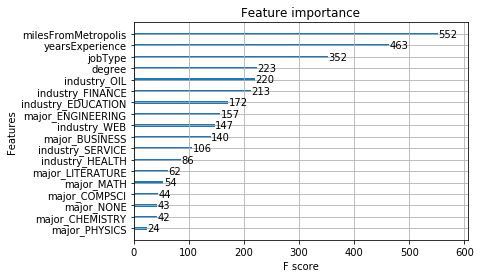

In [164]:
xg.plot_importance(xgb2)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()